In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

In [140]:
train = pd.read_csv("dataset/Train.csv")
test  = pd.read_csv("dataset/Test.csv")

In [29]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68654 entries, 0 to 68653
Data columns (total 16 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ID                           68654 non-null  object 
 1   customer_id                  68654 non-null  int64  
 2   country_id                   68654 non-null  object 
 3   tbl_loan_id                  68654 non-null  int64  
 4   lender_id                    68654 non-null  int64  
 5   loan_type                    68654 non-null  object 
 6   Total_Amount                 68654 non-null  float64
 7   Total_Amount_to_Repay        68654 non-null  float64
 8   disbursement_date            68654 non-null  object 
 9   due_date                     68654 non-null  object 
 10  duration                     68654 non-null  int64  
 11  New_versus_Repeat            68654 non-null  object 
 12  Amount_Funded_By_Lender      68654 non-null  float64
 13  Lender_portion_F

## Data Preprocessing

In [79]:
from sklearn.feature_selection import mutual_info_classif, f_classif

In [25]:
def compute_woe_iv(df, feature, target):
    tab = pd.crosstab(df[feature], df[target])
    tab = tab.rename(columns={0: 'paid', 1: 'defaulted'})
    tab['woe'] = np.log((tab['paid'] / tab['paid'].sum()) / (tab['defaulted'] / tab['defaulted'].sum()))
    tab['iv'] = (tab['paid'] / tab['paid'].sum() - tab['defaulted'] / tab['defaulted'].sum()) * tab['woe']
    tab['iv'] = tab['iv'].cumsum()
    return tab[["woe"]], tab['iv'].iloc[-1]

### Discrete variables and Dates

In [30]:
iv_values = {}
for column in train.select_dtypes(include=['object', 'int64']).columns:
    if column != 'target':
        _, iv = compute_woe_iv(train, column, 'target')
        iv_values[column] = iv

pd.DataFrame(iv_values, index=["Information Value"]).T

,Information Value
ID,inf
customer_id,inf
country_id,0.000000
tbl_loan_id,inf
lender_id,0.881658
loan_type,inf
disbursement_date,inf
due_date,inf
duration,inf
New_versus_Repeat,0.241688


In [31]:
df = train.copy()

In [34]:
df[['disbursement_year', 'disbursement_month', 'disbursement_day']] = df['disbursement_date'].str.split('-', expand=True).astype(int)
df[['due_year', 'due_month', 'due_day']] = df['due_date'].str.split('-', expand=True).astype(int)

iv_values = {}
for column in ['disbursement_year', 'disbursement_month', 'disbursement_day', 'due_year', 'due_month', 'due_day']:
    if column != 'target':
        _, iv = compute_woe_iv(df, column, 'target')
        iv_values[column] = iv

pd.DataFrame(iv_values, index=["Information Value"]).T

,Information Value
disbursement_year,0.623276
disbursement_month,0.585795
disbursement_day,0.081691
due_year,inf
due_month,0.504325
due_day,0.077464


In [43]:
df_temp = df[["duration", "target"]]
df_temp["duration"] = df_temp["duration"].map(
    lambda x: 
        "(0, 7]" if x <= 7 else 
        "(7, 30]" if 7 < x <= 30 else 
        "(30, 90]" if 30 < x <= 90 else 
        "(90, 180]" if 90 < x <= 180 else 
        "(180, 360]" if 180 < x <= 360 else
        "(360, )"
)
print(f"Information value: {compute_woe_iv(df_temp, "duration", "target")[1]}")

Information value: 0.8793294970877753


In [53]:
df["loan_type"] = df["loan_type"].map(lambda x: 1 if x == "type_1" else 0)
print(f"Information value: {compute_woe_iv(df, 'loan_type', 'target')[1]}")

Information value: 0.0


In [54]:
def process_discrete(df):
    return df

In [123]:
df = train.select_dtypes(include=['object', 'int64'])

df['disbursement_date'] = pd.to_datetime(df['disbursement_date'])
df['disbursement_month'] = df['disbursement_date'].dt.month
df['duration'] = df['duration'].map(
    lambda x: 
        "(0, 7]" if x <= 7 else 
        "(7, 30]" if 7 < x <= 30 else 
        "(30, 90]" if 30 < x <= 90 else 
        "(90, 180]" if 90 < x <= 180 else 
        "(180, 360]" if 180 < x <= 360 else
        "(360, )"
)

df = df.drop(columns=[
    'disbursement_date', 'due_date', "customer_id",
    "country_id", "tbl_loan_id", "lender_id",
    "loan_type",
    ])

print(df.info())

iv_values = {}
for column in df.columns:
    if column != 'target':
        _, iv = compute_woe_iv(df, column, 'target')
        iv_values[column] = iv

pd.DataFrame(iv_values, index=["Information Value"]).T

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68654 entries, 0 to 68653
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   ID                  68654 non-null  object
 1   duration            68654 non-null  object
 2   New_versus_Repeat   68654 non-null  object
 3   target              68654 non-null  int64 
 4   disbursement_month  68654 non-null  int32 
dtypes: int32(1), int64(1), object(3)
memory usage: 2.4+ MB
None


,Information Value
ID,inf
duration,0.879329
New_versus_Repeat,0.241688
disbursement_month,0.585795


### Continuous Variables

In [97]:
df = train.copy()

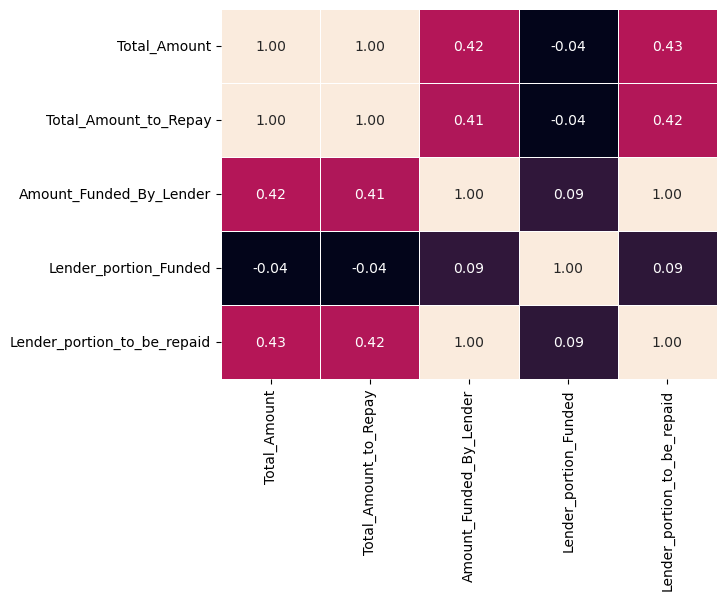

In [98]:
sns.heatmap(
    df.select_dtypes(include=np.float64).corr(),
    annot=True,
    fmt=".2f",
    linewidths=0.5,
    cbar=False
)

plt.show()

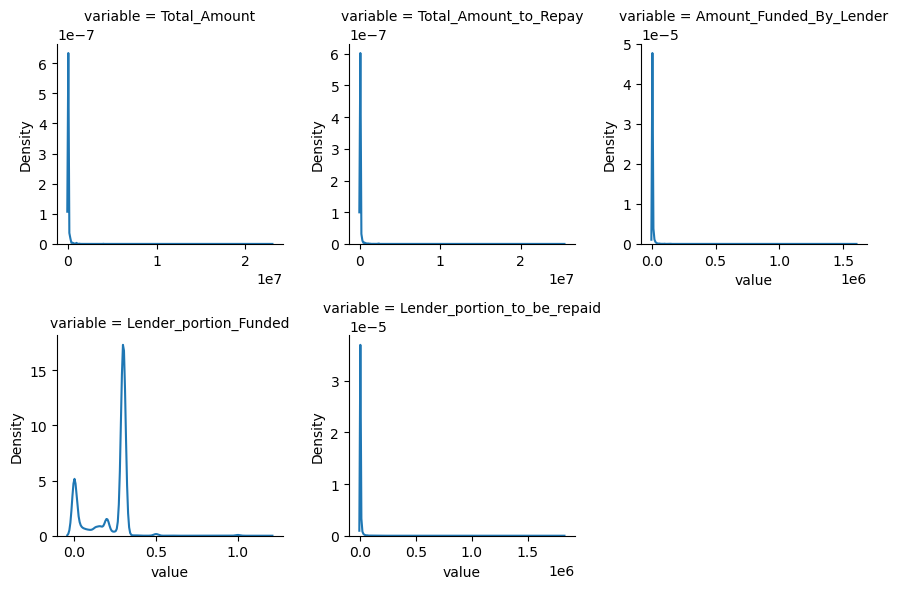

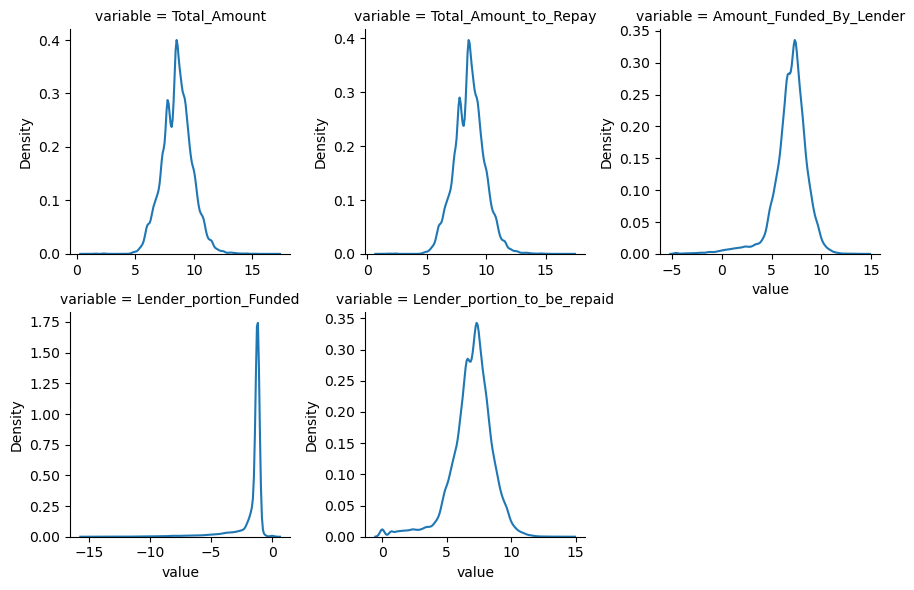

In [99]:
g = sns.FacetGrid(pd.melt(df.select_dtypes(include=np.float64)), col="variable", col_wrap=3, sharex=False, sharey=False)
g.map(sns.kdeplot, "value")
plt.show()

g = sns.FacetGrid(pd.melt(df.select_dtypes(include=np.float64).transform(np.log)), col="variable", col_wrap=3, sharex=False, sharey=False)
g.map(sns.kdeplot, "value")
plt.show()

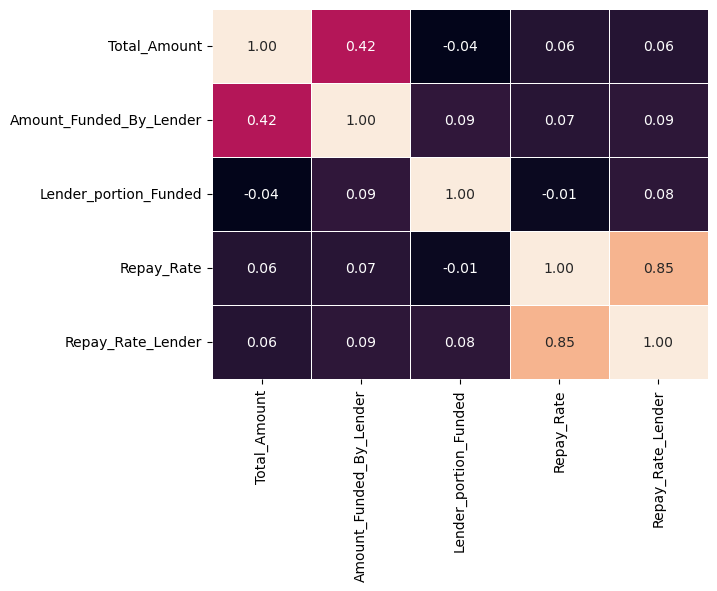

In [128]:
df = train.copy()

df["Repay_Rate"] = (df["Total_Amount_to_Repay"] + 1) / (df["Total_Amount"] + 1)
df["Repay_Rate_Lender"] = (df["Lender_portion_to_be_repaid"] + 1) / (df["Amount_Funded_By_Lender"] + 1)

df = df.drop(columns=["Total_Amount_to_Repay", "Lender_portion_to_be_repaid"])

sns.heatmap(
    df.select_dtypes(include=np.float64).corr(),
    annot=True,
    fmt=".2f",
    linewidths=0.5,
    cbar=False
)

plt.show()

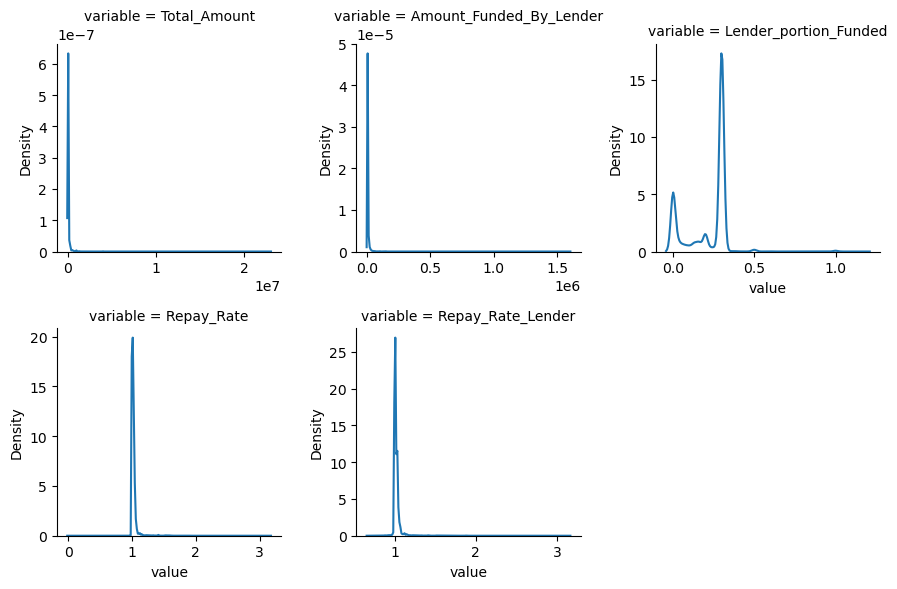

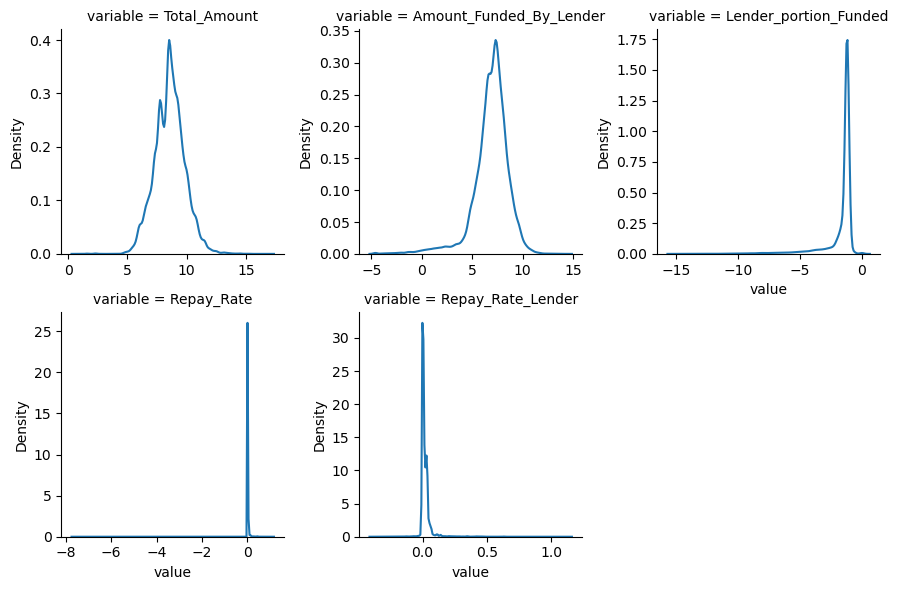

In [129]:
g = sns.FacetGrid(pd.melt(df.select_dtypes(include=np.float64)), col="variable", col_wrap=3, sharex=False, sharey=False)
g.map(sns.kdeplot, "value")
plt.show()

g = sns.FacetGrid(pd.melt(df.select_dtypes(include=np.float64).transform(np.log)), col="variable", col_wrap=3, sharex=False, sharey=False)
g.map(sns.kdeplot, "value")
plt.show()

In [130]:
df_log = df.select_dtypes(include=np.float64).transform(np.log)
df_log.replace([np.inf, -np.inf], np.nan, inplace=True)
df_log.dropna(inplace=True)

df_filtered = df.loc[df_log.index]

f_values, p_values = f_classif(df_log, df_filtered['target'])

f_test_results = pd.DataFrame({
    'Feature': df_log.columns,
    'F-Value': f_values,
    'P-Value': p_values
})

f_test_results

,Feature,F-Value,P-Value
0,Total_Amount,362.411421,1.452155e-80
1,Amount_Funded_By_Lender,220.588080,8.251757e-50
2,Lender_portion_Funded,2.367583,1.238840e-01
3,Repay_Rate,17834.515076,0.000000e+00
4,Repay_Rate_Lender,39197.841260,0.000000e+00


In [366]:
float_columns = df.select_dtypes(include=['float64']).columns

mi_scores = mutual_info_classif(df[float_columns], df['target'])

mi_results = pd.DataFrame({
    'Feature': float_columns,
    'MI Score': mi_scores
})

mi_results

,Feature,MI Score
0,Total_Amount,0.012015
1,Amount_Funded_By_Lender,0.014017
2,Lender_portion_Funded,0.024585
3,Repay_Rate,0.069327
4,Repay_Rate_Lender,0.069058


### Preprocessing Pipe

In [356]:
def preprocess(df):

    df = df.copy()

    # Discrete features and date features
    df['disbursement_date'] = pd.to_datetime(df['disbursement_date'])
    df['disbursement_month'] = df['disbursement_date'].dt.month.astype(np.int64)
    df['duration'] = df['duration'].map(
        lambda x: 
            0 if x <= 7 else 
            1 if 7 < x <= 30 else 
            2 if 30 < x <= 90 else 
            3 if 90 < x <= 180 else 
            4 if 180 < x <= 360 else
            5
    )
    df['New_versus_Repeat'] = df['New_versus_Repeat'].map(lambda x: 1 if x == "New Loan" else 0)

    # Continuous features
    df["Repay_Rate"] = (df["Total_Amount_to_Repay"] + 1) / (df["Total_Amount"] + 1)

    # Drop columns
    df = df.drop(columns=[
        'disbursement_date', 'due_date', "customer_id",
        "country_id", "tbl_loan_id", "lender_id",
        "loan_type", "Total_Amount_to_Repay",
        "Lender_portion_to_be_repaid",
    ])

    return df

## Model

In [372]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, TargetEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, f1_score
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn import set_config

from lightgbm import LGBMClassifier, plot_importance
from xgboost import XGBClassifier

set_config(transform_output="pandas")

In [374]:
df_train = preprocess(train)

print(df_train.info())
print(df_train.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68654 entries, 0 to 68653
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       68654 non-null  object 
 1   Total_Amount             68654 non-null  float64
 2   duration                 68654 non-null  int64  
 3   New_versus_Repeat        68654 non-null  int64  
 4   Amount_Funded_By_Lender  68654 non-null  float64
 5   Lender_portion_Funded    68654 non-null  float64
 6   target                   68654 non-null  int64  
 7   disbursement_month       68654 non-null  int64  
 8   Repay_Rate               68654 non-null  float64
dtypes: float64(4), int64(4), object(1)
memory usage: 4.7+ MB
None
(68654, 9)


In [375]:
X, y = df_train.drop(columns='target'), df_train['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train,  X_val, y_train,  y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

In [360]:
class WoeEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.woe = {}

    def fit(self, X, y):
        for column in X.columns:
            tab = pd.crosstab(X[column], y)
            tab = tab.rename(columns={0: 'paid', 1: 'defaulted'})
            tab["woe"] = np.log((tab['paid'] / tab['paid'].sum()) / (tab['defaulted'] / tab['defaulted'].sum()))
            self.woe[column] = tab['woe'].to_dict()
        return self
    
    def transform(self, X):
        X_transformed = X.copy()
        for column in X.columns:
            X_transformed[column] = X[column].map(self.woe[column])
        return X_transformed
        

### Baseline

In [319]:
model = make_pipeline(
    make_column_transformer(
        (
            make_pipeline(
                SimpleImputer(strategy='mean'),
                StandardScaler(),
            ), make_column_selector(dtype_include=np.float64)),
        (
            make_pipeline(
                SimpleImputer(strategy='most_frequent'),
                WoeEncoder(),
            ), make_column_selector(dtype_include=np.int64)
        ),
        remainder='drop'
    ),
    LogisticRegression(),
)

model.fit(X_train, y_train)

y_pred = model.predict(X_val)

print("Train f1 score: ", f1_score(y_train, model.predict(X_train)))
print("Validation f1 score: ", f1_score(y_val, y_pred))
print("\n")
print(classification_report(y_val, y_pred))

Train f1 score:  0.6139817629179332
Validation f1 score:  0.6467065868263473


              precision    recall  f1-score   support

           0       0.99      1.00      0.99     10784
           1       0.81      0.54      0.65       201

    accuracy                           0.99     10985
   macro avg       0.90      0.77      0.82     10985
weighted avg       0.99      0.99      0.99     10985



### Models

In [361]:
model = make_pipeline(
    make_column_transformer(
        (
            make_pipeline(
                SimpleImputer(strategy='mean'),
                #StandardScaler(),
            ), make_column_selector(dtype_include=np.float64)),
        (
            make_pipeline(
                SimpleImputer(strategy='most_frequent'),
                #WoeEncoder(),
            ), make_column_selector(dtype_include=np.int64)
        ),
        remainder='drop'
    ),
    LGBMClassifier(verbose=-1, n_estimators=50, max_depth=3),
)

model.fit(X_train, y_train)

thresh = 0.5

y_val_pred   = (model.predict_proba(X_val)   > thresh).argmax(axis=1)
y_train_pred = (model.predict_proba(X_train) > thresh).argmax(axis=1)

model.predict = lambda X: (model.predict_proba(X) > thresh).argmax(axis=1)

print("Train f1 score: ", f1_score(y_train, y_train_pred))
print("Validation f1 score: ", f1_score(y_val, y_val_pred))
print("\n")
print(classification_report(y_val, y_val_pred))

Train f1 score:  0.8125836680053548
Validation f1 score:  0.7989276139410187


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10784
           1       0.87      0.74      0.80       201

    accuracy                           0.99     10985
   macro avg       0.93      0.87      0.90     10985
weighted avg       0.99      0.99      0.99     10985



In [ ]:
model = make_pipeline(
    make_column_transformer(
        (
            make_pipeline(
                SimpleImputer(strategy='mean'),
                #StandardScaler(),
            ), make_column_selector(dtype_include=np.float64)),
        (
            make_pipeline(
                SimpleImputer(strategy='most_frequent'),
                WoeEncoder(),
            ), make_column_selector(dtype_include=np.int64)
        ),
        remainder='drop'
    ),
    LGBMClassifier(n_estimators=50, max_depth=3, random_state=42, verbose=-1)
)

model.fit(X_train, y_train)

thresh = 0.5

y_val_pred   = (model.predict_proba(X_val)   > thresh).argmax(axis=1)
y_train_pred = (model.predict_proba(X_train) > thresh).argmax(axis=1)

model.predict = lambda X: (model.predict_proba(X) > thresh).argmax(axis=1)

print("Train f1 score: ", f1_score(y_train, y_train_pred))
print("Validation f1 score: ", f1_score(y_val, y_val_pred))
print("\n")
print(classification_report(y_val, y_val_pred))

Train f1 score:  0.7966919365954515
Validation f1 score:  0.7762039660056658


              precision    recall  f1-score   support

           0       0.99      1.00      1.00     10784
           1       0.90      0.68      0.78       201

    accuracy                           0.99     10985
   macro avg       0.95      0.84      0.89     10985
weighted avg       0.99      0.99      0.99     10985



In [363]:
print("Test f1 score: ", f1_score(y_test, model.predict(X_test)))

Test f1 score:  0.7768595041322314


### Submission

In [364]:
# Make submission

df_test = preprocess(test)

model.fit(X, y)

y_pred = model.predict(df_test)

print(classification_report(y, model.predict(X)))

submission = pd.DataFrame({
    "ID": test["ID"],
    "target": y_pred
})

submission.to_csv("submission.csv", index=False)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     67396
           1       0.89      0.73      0.80      1258

    accuracy                           0.99     68654
   macro avg       0.94      0.87      0.90     68654
weighted avg       0.99      0.99      0.99     68654



---